In [ ]:
!pip install --upgrade gdown

In [1]:
# Install libraries
!pip -q install lightning 

# Import libraries

* Set all random seed to 0

In [2]:

from glob import glob
import pandas as pd
import numpy as np
import os
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import gc
from lightning.pytorch.callbacks import ModelSummary


# Set stable random
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 0


Assign data path

In [3]:
train_path = '/melanoma_cancer_dataset/train'
list_label = [name for name in os.listdir(train_path)]
list_label

['malignant', 'benign']

Get path

In [4]:
def get_path(path):
    paths = []
    for i, name in enumerate(list_label):
        l = glob(os.path.join(path, name, '*.jpg'))
        for li in l:
            paths.append(
                {
                    'name': name,
                    'path': li,
                    'label': i
                }
            )
    
    return paths

data_paths = get_path(train_path)
len(data_paths)

10605

Split data into 3 parts: train, validation, test

In [5]:
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=0)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

len(train_paths), len(val_paths), len(test_paths)  

(6787, 1697, 2121)

Dataset module

In [6]:
class DataSet(torch.utils.data.Dataset):
    """Encapsure dataset for pytorch format

    Args:
        features: list of dict
        transform: pytorch transform
    
    Returns:
        dict: {
            'images': torch.tensor,
            'labels': torch.tensor
        }
    """
    
    
    
    def __init__(self, features, transform = None):
        super(DataSet, self).__init__()
        self.features = features
        self.transform = transform

    # Get length of dataset
    def __len__(self):
        return len(self.features)

    # Get item of dataset and transform image and label to homogeneous format like torch tensor
    def __getitem__(self, index):
        paths = self.features[index]['path']
        images = torchvision.io.read_image(paths)
        images = torch.stack([images[0], images[0], images[0]], dim = 0) 

        if self.transform is not None:
            images = self.transform(images)
            
        label = torch.tensor(self.features[index]['label'])
        return {
            'images': images,
            'labels': label
        }
        
Data = DataSet(data_paths)
next(iter(Data))['images'].shape

torch.Size([3, 300, 300])

* We have size of image: 300x300x3

Show image of dataset

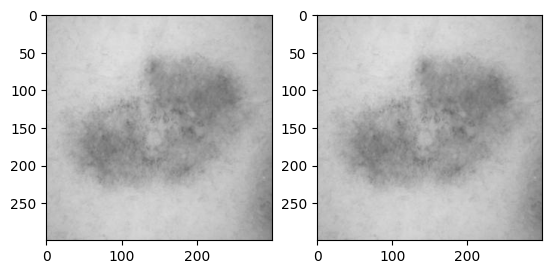

In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    
    for i, img in  enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap='gray')

show([next(iter(Data))['images'], next(iter(Data))['images']])

Get data module

In [8]:
class DataModule(L.LightningDataModule):
    """
    Encapsure dataset for pytorch lightning and transform variety of properties of image to increase point of view for model ,then separate each batch in all dataset
    """
    
    
    def __init__(self, batch_size, num_workers, data_path, size_img = (224, 224)):
        """
        Args:
            batch_size (int): max batch size of dataset 
            num_workers (int): number of thread to processing data
            data_path (str): path to dataset
        """
        super(DataModule, self).__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_path = data_path
        self.size_img = size_img
        
        # List of transform Compose
        self.train_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(self.size_img),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1

                ),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

            ]
        )
        
        self.test_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(self.size_img),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1

                ),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

            ]
        )
    
    # Preprocessing for train dataset
    def setup(self, stage=None):
        
        # Split train, val, test
        data_paths = get_path(self.data_path)
        train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=0)
        train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)
        
        # Put paths into dataset class
        self.train_dataset = DataSet(
            train_paths,
            transform=self.train_transform
        )
        
        self.valid_dataset = DataSet(
            val_paths,
            transform=self.test_transform
        )
        
        self.test_dataset = DataSet(
            test_paths,
            transform=self.test_transform
        )
        
    # Load train dataset into dataloader to separate batch for easy training
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

data_module = DataModule(
    batch_size=32,
    num_workers=8,
    data_path=train_path
)

data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()               

In [ ]:
next(iter(train_loader))['images'].shape

torch.Size([32, 3, 224, 224])

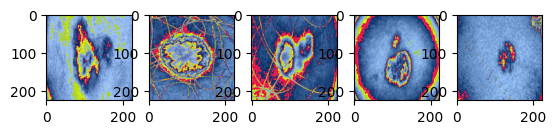

In [ ]:
# Show image in train loader
images = [image for image in next(iter(train_loader))['images']]
show(images[:5])

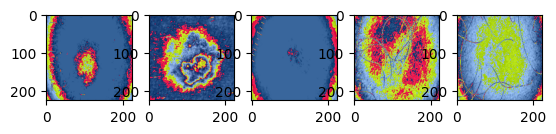

In [ ]:
# Show image in validation loader
images = [image for image in next(iter(val_loader))['images']]
show(images[:5])

# Test variant of model

## VGG 16 model

![Model VGG16 architecture](https://www.researchgate.net/publication/359771670/figure/fig5/AS:11431281079634597@1660789329088/VGG-19-Architecture-39-VGG-19-has-16-convolution-layers-grouped-into-5-blocks-After.png)

In [9]:
# Define a LightningModule using VGG16 from library
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        
        # Last Layer Linearize
        self.classifer = nn.Sequential(

            # First Linear
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            # Second Linear
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            # Last Layer for classification
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64,       64, 'M',
                     128,      128, 'M',
                     256, 256, 256, 'M',
                     512, 512, 512, 'M',
                     512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = v,
                    kernel_size = 3,
                    padding = 1
                )
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


In [82]:
# Define a LightningModule using the custom model input
class CustomModel(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4, model = VGG16, aux_phase = False, **kwargs):
        super(CustomModel, self).__init__()
        self.model = model(num_classes=num_classes, **kwargs)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()
        self.save_hyperparameters()
        self.aux_phase = aux_phase

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        
        if self.aux_phase:
            y_hat, aux = self(x)
            loss = self.loss(y_hat, y) + 0.3*self.loss(aux, y)
        else:
            y_hat = self(x)
            loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        if self.aux_phase:
            y_hat, aux = self(x)
            val_loss = self.loss(y_hat, y) + 0.3*self.loss(aux, y)
        else:
            y_hat = self(x)
            val_loss = self.loss(y_hat, y)
            
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        if self.aux_phase:
            y_hat, aux = self(x)
            test_loss = self.loss(y_hat, y) + 0.3*self.loss(aux, y)
        else:
            y_hat = self(x)
            test_loss = self.loss(y_hat, y)
            
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        if self.aux_phase:
            y_hat, aux = self(x)
        else:
            y_hat= self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)
        return {'y_pred': predicted_labels[1], 'y_prob': predicted_labels[0]}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Traing with model VGG16
# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/VGG16_normal',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_vgg16_normal = CustomModel(model = VGG16)

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)
trainer_vgg16_normal = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_vgg16_normal.fit(model_vgg16_normal, data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16            | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.78197 (best 0.78197), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=0-step=54-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.80966 (best 0.80966), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' reached 0.82499 (best 0.82499), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=2-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.84148 (best 0.84148), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.85209 (best 0.85209), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' reached 0.88863 (best 0.88863), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=5-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' reached 0.89039 (best 0.89039), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=6-step=378.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' reached 0.89452 (best 0.89452), saving model to '/notebooks/checkpoint/VGG16_normal/epoch=8-step=486-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Testing in training set
trainer_vgg16_normal.tt(model_vgg16_normal, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8628005385398865     │
│         test_loss         │    0.3171926438808441     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3171926438808441, 'test_acc': 0.8628005385398865}]

In [11]:
# Data for testing
data_module = DataModule(
    batch_size = 64, num_workers = 8, data_path = train_path
)
data_module.setup()
test_loader = data_module.test_dataloader()


In [12]:
## Get label of test set
def get_predictions(data_module,model, trainer):
    test_loader = data_module.test_dataloader()
    
    predictions_ = trainer.predict(model, test_loader)
    all_max_indices = torch.tensor([])
    all_prob = torch.tensor([])
    for i in predictions_:
        all_max_indices = torch.concat([all_max_indices,i['y_pred']])
        all_prob = torch.concat([all_prob,i['y_prob']])
    
    return all_max_indices, all_prob

In [ ]:
# Predict stage
 
model_vgg16_normal = CustomModel.load_from_checkpoint(
    '/checkpoint/VGG16_normal/epoch=8-step=486-v2.ckpt'
)  
all_max_indices, all_prob = get_predictions(data_module, model_vgg16_normal, trainer_vgg16_normal)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show prediction image of model

In [13]:
# Show image function 
def plot_image(i, imgs, pred_labels, probs):
    true_label, img, pred_label, prob = imgs[i]['labels'], imgs[i]['images'], pred_labels[i], probs[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap=plt.cm.binary)

    color = ('green' if pred_label == true_label else 'red')
    plt.xlabel("Predict: {} {:2.0f}% (True: {})".format(list_label[int(pred_label)],100*prob, list_label[int(true_label)]), color=color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Show images prediction


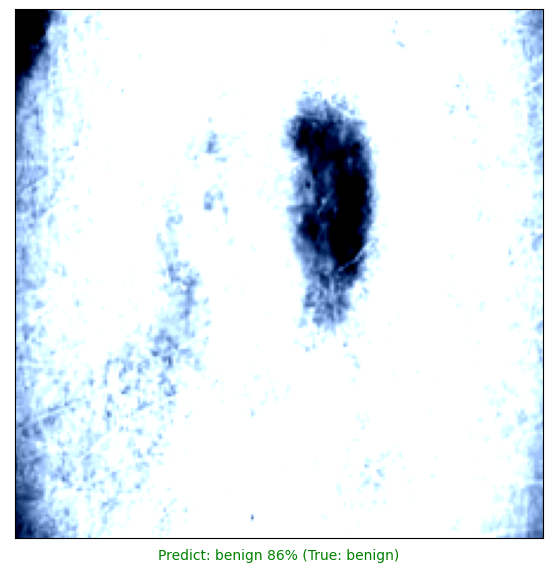

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


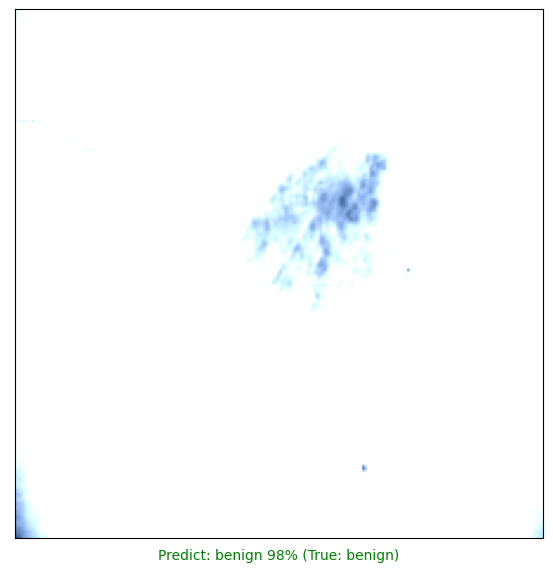

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


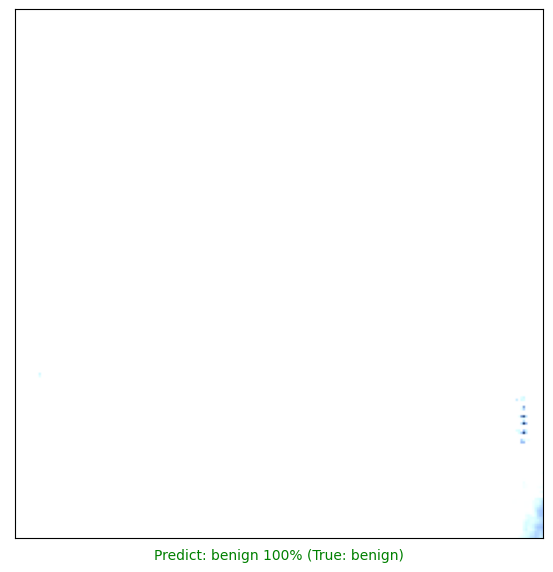

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


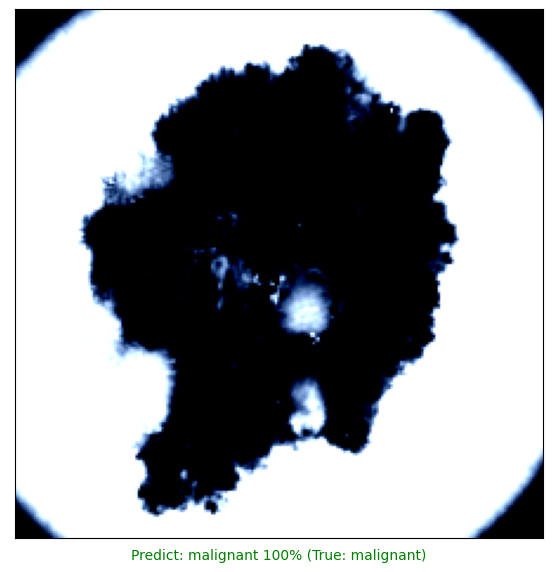

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


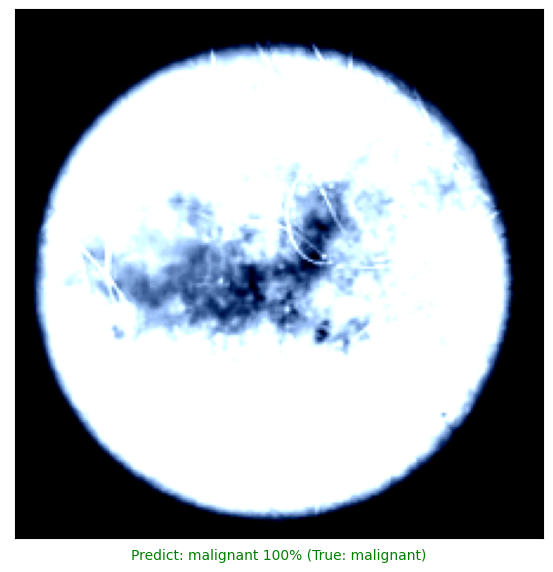

In [ ]:
lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()


Show result of model: classification report + confusion matrix

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_labels = [int(t['labels']) for t in test_loader.dataset]

def show_result(test_labels,pred_labels):
    #### Classification Report ####
    print('*'*50)
    print('Classification Report:\n')
    print(classification_report(test_labels, pred_labels, target_names=list_label))
    print()    
    print('*'*50)
    
    #### Confusion Matrix ####
    plt.figure(figsize=(10,10))
    print('Confusion Matrix:\n')
    cm = confusion_matrix(test_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt="d")

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.93      0.78      0.85      1001
      benign       0.83      0.95      0.89      1120

    accuracy                           0.87      2121
   macro avg       0.88      0.87      0.87      2121
weighted avg       0.88      0.87      0.87      2121


**************************************************
Confusion Matrix:


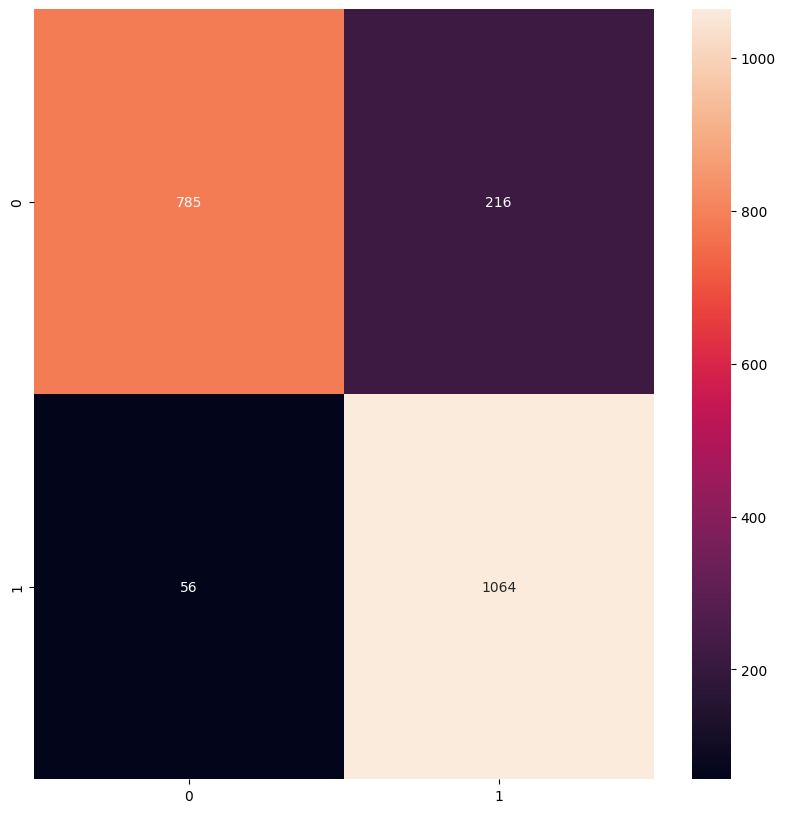

In [ ]:
show_result(test_labels ,all_max_indices)

## VGG 16 C model

In [15]:
class VGG16_C(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_C, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64,        64, 'M',
                      128,      128, 'M',
                      256, 256, '256_c1', 'M',
                      512, 512, '512_c1', 'M',
                      512, 512, '512_c1', 'M']


        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                if isinstance(v, str):
                    v = int(v.split('_')[0])
                    conv = nn.Conv2d(in_channels, v, kernel_size=1, padding=0, stride=1)
                else:
                    conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


In [ ]:
# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/VGG16_C',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_vgg16_c = CustomModel(model = VGG16_C)


data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)

trainer_vgg16_c = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_vgg16_c.fit(model_vgg16_c, data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /notebooks/checkpoint/VGG16_C exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16_C          | 129 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
129 M     Trainable params
0         Non-trainable params
129 M     Total params
518.201   Total estimated model p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.75899 (best 0.75899), saving model to '/notebooks/checkpoint/VGG16_C/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.79552 (best 0.79552), saving model to '/notebooks/checkpoint/VGG16_C/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.82793 (best 0.82793), saving model to '/notebooks/checkpoint/VGG16_C/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' reached 0.85386 (best 0.85386), saving model to '/notebooks/checkpoint/VGG16_C/epoch=5-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' reached 0.85916 (best 0.85916), saving model to '/notebooks/checkpoint/VGG16_C/epoch=7-step=432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' reached 0.86977 (best 0.86977), saving model to '/notebooks/checkpoint/VGG16_C/epoch=8-step=486.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' reached 0.87979 (best 0.87979), saving model to '/notebooks/checkpoint/VGG16_C/epoch=9-step=540-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Testing in training set
trainer_vgg16_c.test(model_vgg16_c, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8844884634017944     │
│         test_loss         │    0.2688867747783661     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2688867747783661, 'test_acc': 0.8844884634017944}]

In [ ]:

model_vgg16_c = CustomModel.load_from_checkpoint(
    '/checkpoint/VGG16_C/epoch=9-step=540-v1.ckpt'
)  
all_max_indices, all_prob = get_predictions(data_module, model_vgg16_c, trainer_vgg16_c)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show result of model: classification report + confusion matrix

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.81      0.92      0.86      1001
      benign       0.91      0.80      0.85      1120

    accuracy                           0.86      2121
   macro avg       0.86      0.86      0.86      2121
weighted avg       0.86      0.86      0.86      2121


**************************************************
Confusion Matrix:


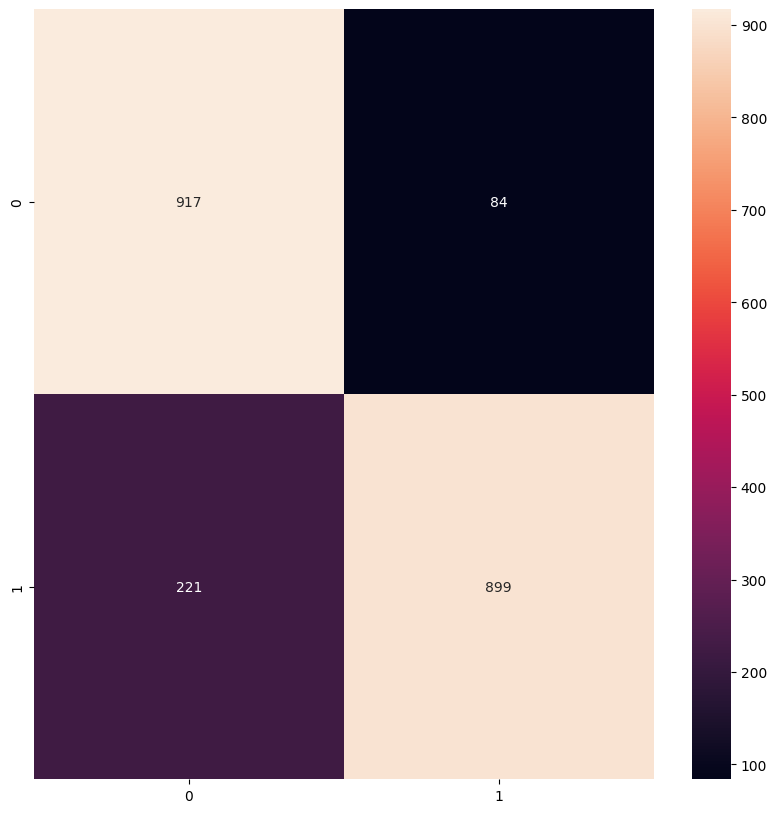

In [ ]:
show_result(test_labels ,all_max_indices)

## Inception V3 model

![Model Inception V3 architecture](https://www.researchgate.net/publication/331980242/figure/fig19/AS:743367646380035@1554244066286/Architecture-of-the-Inception-V3-module-41.png)

In [ ]:

from ModelCommonCNN.Model.InceptionV3 import InceptionV3
# Traing with model VGG16
# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/InceptionV3',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_inceptionv3 = CustomModel(model = InceptionV3,aux_phase=True)

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path, 
    size_img = (299, 299) 
)
trainer_inceptionv3 = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_inceptionv3.fit(model_inceptionv3, data_module)

/notebooks/ModelCommonCNN/Model/InceptionV3.py:717: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.75486 (best 0.75486), saving model to '/notebooks/checkpoint/InceptionV3/epoch=0-step=54-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.80200 (best 0.80200), saving model to '/notebooks/checkpoint/InceptionV3/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' reached 0.82557 (best 0.82557), saving model to '/notebooks/checkpoint/InceptionV3/epoch=2-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.83559 (best 0.83559), saving model to '/notebooks/checkpoint/InceptionV3/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' reached 0.84266 (best 0.84266), saving model to '/notebooks/checkpoint/InceptionV3/epoch=6-step=378.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' reached 0.85209 (best 0.85209), saving model to '/notebooks/checkpoint/InceptionV3/epoch=9-step=540-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Testing in training set
trainer_inceptionv3.test(model_inceptionv3, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8349835276603699     │
│         test_loss         │    0.4117653965950012     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4117653965950012, 'test_acc': 0.8349835276603699}]

In [ ]:
all_max_indices, all_prob = get_predictions(data_module, model_inceptionv3, trainer_inceptionv3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.85      0.83      0.84      1001
      benign       0.85      0.87      0.86      1120

    accuracy                           0.85      2121
   macro avg       0.85      0.85      0.85      2121
weighted avg       0.85      0.85      0.85      2121


**************************************************
Confusion Matrix:



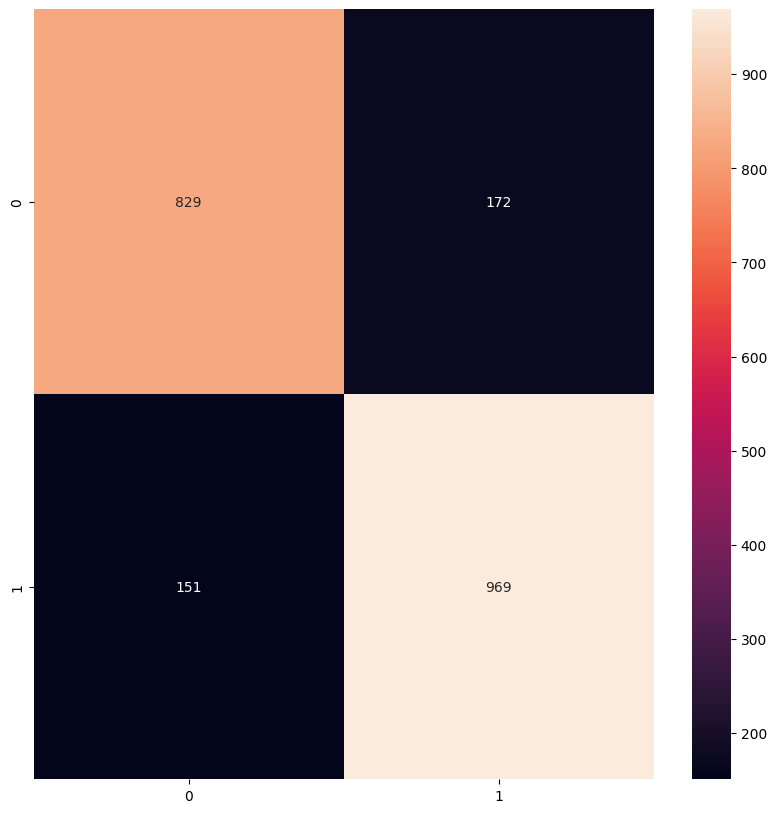

In [ ]:
show_result(test_labels ,all_max_indices)

## ResNet model

![Model ResNet architecture](https://wisdomml.in/wp-content/uploads/2023/03/resnet_bannner.png)

Original ResNet50 model

In [61]:
from ModelCommonCNN.Model.ResNet import ResNet, Bottleneck

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/ResNet',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_resnet = CustomModel(model = ResNet, block = Bottleneck)

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)
trainer_resnet = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_resnet.fit(model_resnet, data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /notebooks/checkpoint/ResNet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 23.5 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.67295 (best 0.67295), saving model to '/notebooks/checkpoint/ResNet/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.71067 (best 0.71067), saving model to '/notebooks/checkpoint/ResNet/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' reached 0.75192 (best 0.75192), saving model to '/notebooks/checkpoint/ResNet/epoch=2-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.88097 (best 0.88097), saving model to '/notebooks/checkpoint/ResNet/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [62]:
# Testing in training set
trainer_resnet.test(model_resnet, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8396982550621033     │
│         test_loss         │    0.3539535403251648     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3539535403251648, 'test_acc': 0.8396982550621033}]

In [63]:
all_max_indices, all_prob = get_predictions(data_module, model_resnet, trainer_resnet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.80      0.89      0.84      1001
      benign       0.89      0.80      0.84      1120

    accuracy                           0.84      2121
   macro avg       0.84      0.84      0.84      2121
weighted avg       0.85      0.84      0.84      2121


**************************************************
Confusion Matrix:



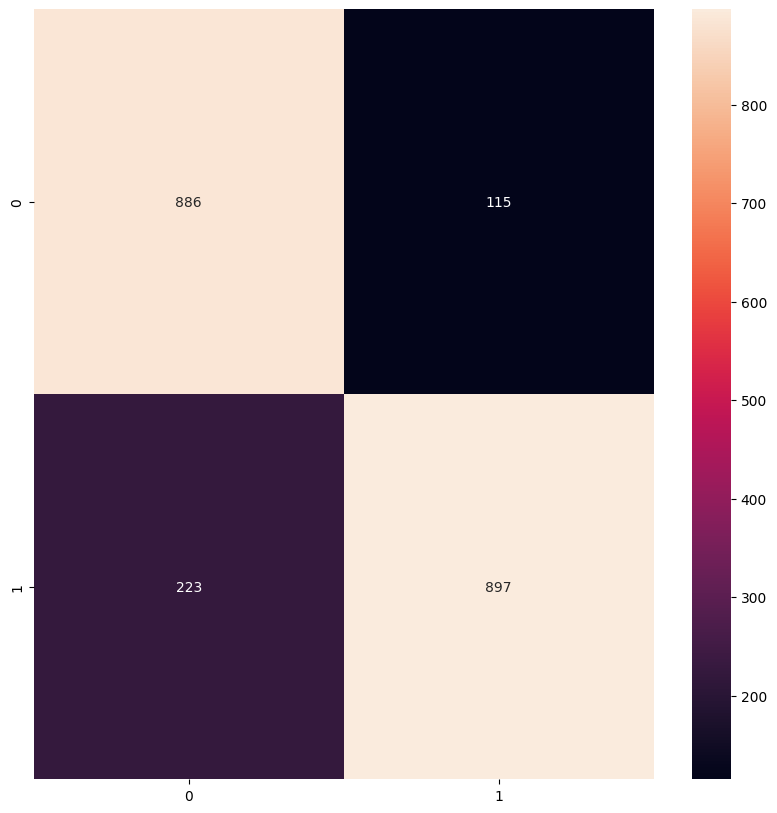

In [64]:
show_result(test_labels ,all_max_indices)

Pre-trained ResNet50 model

In [80]:
class PreTrainedResNet(nn.Module):
    def __init__(
        self, is_train=False,          
        num_classes=2,
        backbone=torchvision.models.resnet50(weights="DEFAULT")
    ) -> None:
        
        super(PreTrainedResNet, self).__init__()

        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        self.feature_extractor = torch.nn.Sequential(*layers)
        self.classifier = torch.nn.Linear(
                in_features=num_filters, 
                out_features=num_classes
        )
        
        self.is_train = is_train
        

    def forward(self, x):
        self.feature_extractor.eval()
        if self.is_train:
            representations = self.feature_extractor(x).flatten(1)
        else:
            with torch.no_grad():
                representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [84]:
# from ModelCommonCNN.Model.ResNet import ResNet, Bottleneck

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/PreTrainedResNet',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_pretrained_resnet = CustomModel(model = PreTrainedResNet)

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)
trainer_pretrained_resnet = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_pretrained_resnet.fit(model_pretrained_resnet, data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PreTrainedResNet | 23.5 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.83618 (best 0.83618), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.85622 (best 0.85622), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' reached 0.86859 (best 0.86859), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=2-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.87979 (best 0.87979), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.88097 (best 0.88097), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' reached 0.88273 (best 0.88273), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=5-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' reached 0.89216 (best 0.89216), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=6-step=378.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' reached 0.89393 (best 0.89393), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=7-step=432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' reached 0.89629 (best 0.89629), saving model to '/notebooks/checkpoint/PreTrainedResNet/epoch=9-step=540.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [85]:
# Testing in training set
trainer_pretrained_resnet.test(model_pretrained_resnet, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8887317180633545     │
│         test_loss         │    0.2877328395843506     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2877328395843506, 'test_acc': 0.8887317180633545}]

In [86]:
all_max_indices, all_prob = get_predictions(data_module, model_pretrained_resnet, trainer_pretrained_resnet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.91      0.86      0.88      1001
      benign       0.88      0.93      0.90      1120

    accuracy                           0.89      2121
   macro avg       0.90      0.89      0.89      2121
weighted avg       0.90      0.89      0.89      2121


**************************************************
Confusion Matrix:



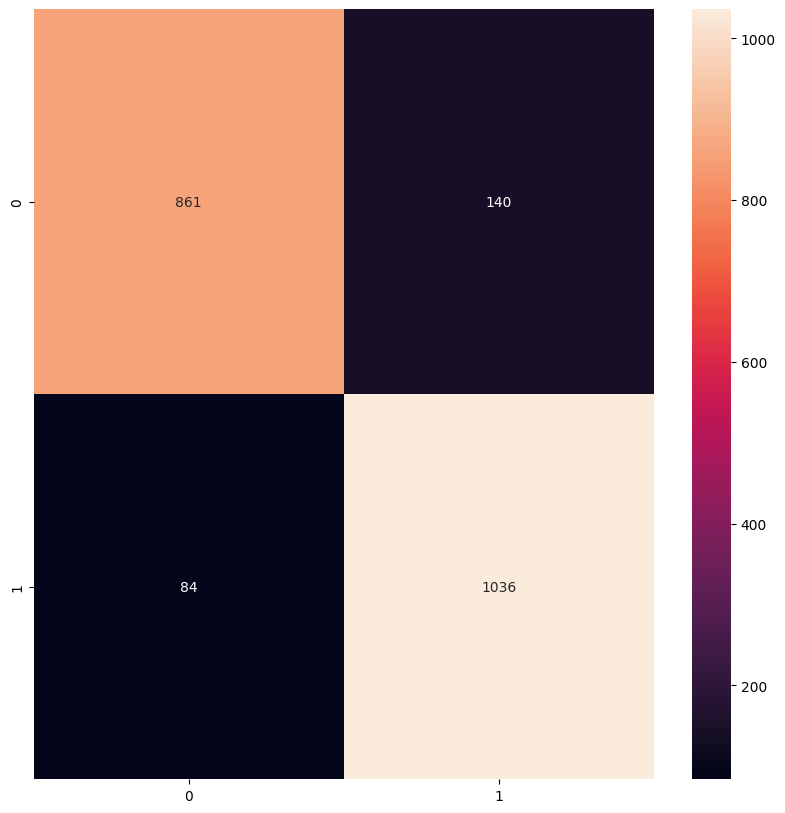

In [87]:
show_result(test_labels ,all_max_indices)

Pre-trained ResNet152 model

In [88]:
# from ModelCommonCNN.Model.ResNet import ResNet, Bottleneck

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/ResNet/ResNet152',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_resnet152 = CustomModel(model = PreTrainedResNet, backbone = torchvision.models.resnet152(weights="DEFAULT"))

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)
trainer_resnet152 = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_resnet152.fit(model_resnet152, data_module)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PreTrainedResNet | 58.1 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
58.1 M    Traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.86270 (best 0.86270), saving model to '/notebooks/checkpoint/ResNet/ResNet152/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.88745 (best 0.88745), saving model to '/notebooks/checkpoint/ResNet/ResNet152/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.89275 (best 0.89275), saving model to '/notebooks/checkpoint/ResNet/ResNet152/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.90807 (best 0.90807), saving model to '/notebooks/checkpoint/ResNet/ResNet152/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [89]:
# Testing in training set
trainer_resnet152.test(model_resnet152, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8958038687705994     │
│         test_loss         │    0.2721489667892456     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2721489667892456, 'test_acc': 0.8958038687705994}]

In [90]:
all_max_indices, all_prob = get_predictions(data_module, model_resnet152, trainer_resnet152)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.91      0.87      0.89      1001
      benign       0.89      0.93      0.91      1120

    accuracy                           0.90      2121
   macro avg       0.90      0.90      0.90      2121
weighted avg       0.90      0.90      0.90      2121


**************************************************
Confusion Matrix:



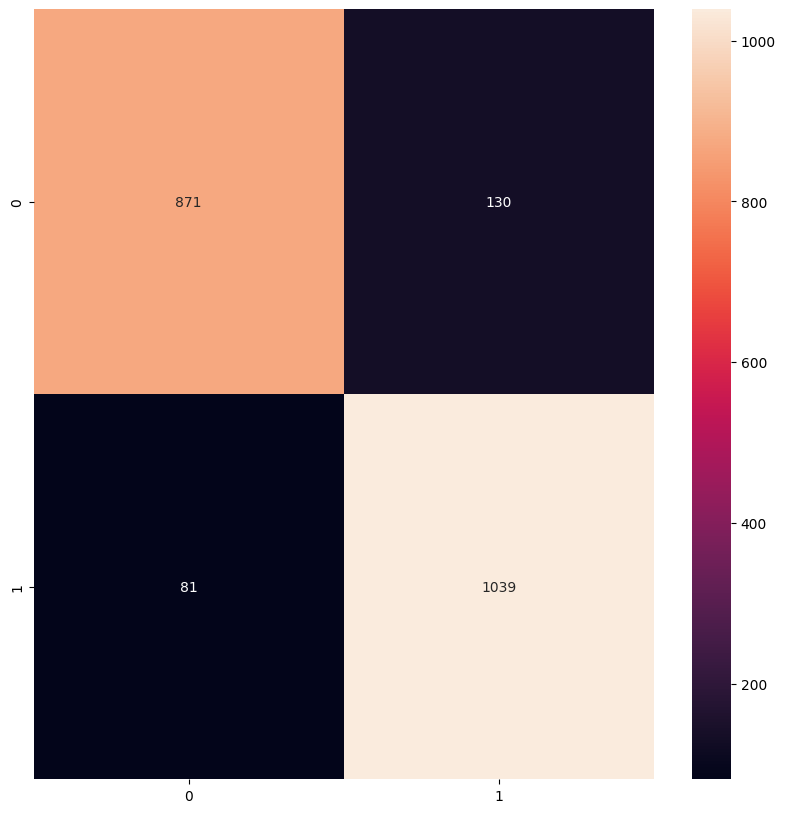

In [91]:
show_result(test_labels ,all_max_indices)

EfficientNetB7 model

In [102]:
from torchvision.models import EfficientNet_B7_Weights 


class PreTrainedEfficientNet(nn.Module):
    def __init__(
        self, is_train=False,          
        num_classes=2,
        backbone=torchvision.models.efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
    ) -> None:
        
        super(PreTrainedEfficientNet, self).__init__()

        num_filters = backbone.classifier[1].in_features
        layers = list(backbone.children())[:-1]

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            torch.nn.Dropout(p=0.5, inplace=True),
            torch.nn.Linear(
                    in_features=num_filters, 
                    out_features=num_classes
            )
        )
        self.is_train = is_train
        

    def forward(self, x):
        self.feature_extractor.eval()
        if self.is_train:
            representations = self.feature_extractor(x).flatten(1)
        else:
            with torch.no_grad():
                representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

In [103]:
# from ModelCommonCNN.Model.ResNet import ResNet, Bottleneck

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/EfficientNet/B7',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_efficientnet = CustomModel(model = PreTrainedResNet)

data_module = DataModule(
    batch_size = 128, num_workers = 8,
    data_path = train_path 
)
trainer_efficientnet = L.Trainer(
    max_epochs = 10,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_efficientnet.fit(model_efficientnet, data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PreTrainedResNet | 23.5 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'val_acc' reached 0.80849 (best 0.80849), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 108: 'val_acc' reached 0.83795 (best 0.83795), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=1-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 162: 'val_acc' reached 0.85504 (best 0.85504), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=2-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 216: 'val_acc' reached 0.86682 (best 0.86682), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=3-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 270: 'val_acc' reached 0.87861 (best 0.87861), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=4-step=270.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 324: 'val_acc' reached 0.87920 (best 0.87920), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=5-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 378: 'val_acc' reached 0.88627 (best 0.88627), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=6-step=378.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 432: 'val_acc' reached 0.88981 (best 0.88981), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=7-step=432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 486: 'val_acc' reached 0.89511 (best 0.89511), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=8-step=486.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 540: 'val_acc' reached 0.90100 (best 0.90100), saving model to '/notebooks/checkpoint/EfficientNet/B7/epoch=9-step=540.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [104]:
# Testing in training set
trainer_efficientnet.test(model_efficientnet, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8892031908035278     │
│         test_loss         │    0.2907809317111969     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2907809317111969, 'test_acc': 0.8892031908035278}]

In [105]:
all_max_indices, all_prob = get_predictions(data_module, model_efficientnet, trainer_efficientnet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Classification Report:

              precision    recall  f1-score   support

   malignant       0.91      0.85      0.88      1001
      benign       0.88      0.92      0.90      1120

    accuracy                           0.89      2121
   macro avg       0.89      0.89      0.89      2121
weighted avg       0.89      0.89      0.89      2121


**************************************************
Confusion Matrix:



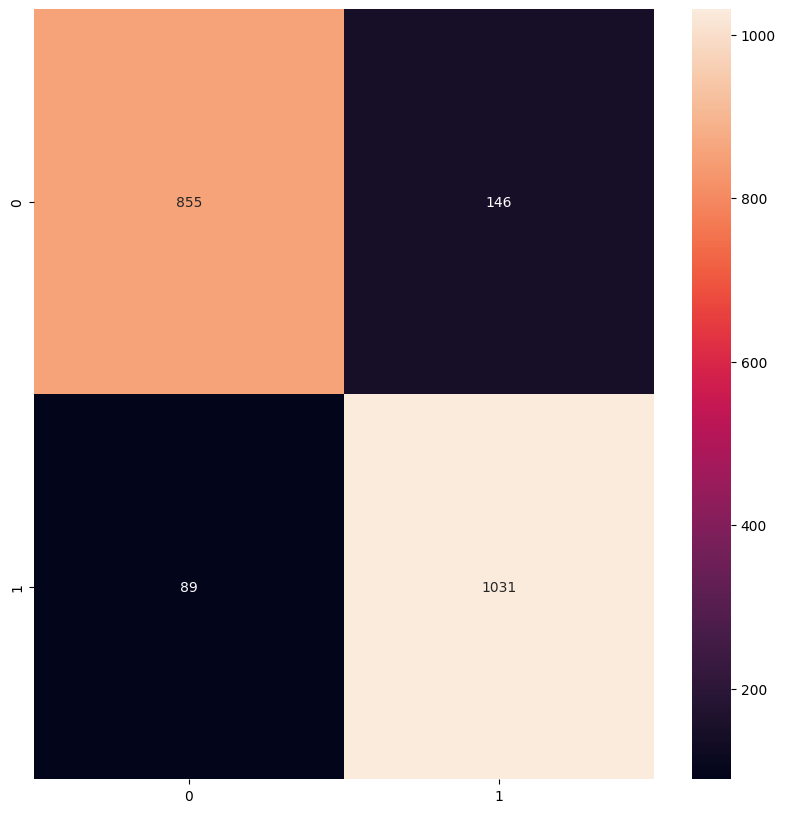

In [106]:
show_result(test_labels ,all_max_indices)